In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import gc
import datetime
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.preprocessing import MinMaxScaler,LabelEncoder, StandardScaler, RobustScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler

In [2]:
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
train_transaction=pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
train_identity=pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
test_transaction=pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv')
test_identity=pd.read_csv('../input/ieee-fraud-detection/test_identity.csv')
sample_submission=pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')

In [4]:
train_df = train_transaction.merge(train_identity, how="left", on="TransactionID")

test_df = test_transaction.merge(test_identity, how="left", on="TransactionID")

In [5]:
test_df= test_df.rename(columns=lambda x:"_".join(x.split("-")))

#### reduce memory

In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
train_df = reduce_mem_usage(train_df)
test_df  = reduce_mem_usage(test_df)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


# Fill NA

In [8]:
train_df = train_df.fillna(-999)
test_df = test_df.fillna(-999)

# Label Encoding

In [9]:
# Label Encoding
for f in train_df.columns:
    if train_df[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values)) 

In [10]:
for f in test_df.columns:
    if test_df[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(test_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

# Model

In [11]:
y = train_df["isFraud"]
X = train_df.drop(["isFraud", "TransactionID"], axis=1)
test_df = test_df.drop(["TransactionID"], axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# lightgbm

In [13]:
reg1 = LGBMClassifier()
reg1.fit(X_train,y_train) 

LGBMClassifier()

In [14]:
pred = reg1.predict(X_test)
print(classification_report(y_test, pred))
print(f"Auc: {round(roc_auc_score(pred, y_test), 2)}")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    170963
           1       0.89      0.44      0.59      6199

    accuracy                           0.98    177162
   macro avg       0.94      0.72      0.79    177162
weighted avg       0.98      0.98      0.97    177162

Auc: 0.94


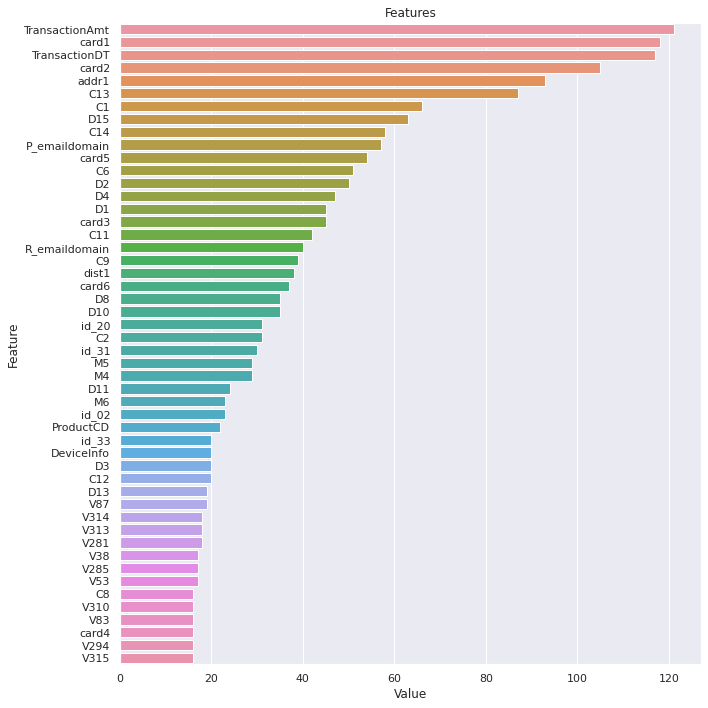

In [15]:
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:50])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

        
        
plot_importance(reg1, X_train)

In [16]:
predictions = reg1.predict_proba(test_df)[:,1]

In [17]:
submission = pd.DataFrame({'TransactionID':test_transaction['TransactionID'],'isFraud':predictions})
submission["TransactionID"]=submission["TransactionID"].astype(int)
submission.head()

,TransactionID,isFraud
0,3663549,0.003975
1,3663550,0.004518
2,3663551,0.011299
3,3663552,0.002218
4,3663553,0.003725


In [18]:
filename = 'CIS Fraud Detection LGBM.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: CIS Fraud Detection LGBM.csv


In [19]:
# Score: 0.893605
# Public score: 0.918328

# xgb

In [20]:
reg2 = XGBClassifier() 
reg2.fit(X_train,y_train) 

[17:27:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
pred2 = reg2.predict(X_test)
print(classification_report(y_test, pred2))
print(f"Auc: {round(roc_auc_score(pred2, y_test), 2)}")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    170963
           1       0.92      0.49      0.64      6199

    accuracy                           0.98    177162
   macro avg       0.95      0.75      0.82    177162
weighted avg       0.98      0.98      0.98    177162

Auc: 0.95


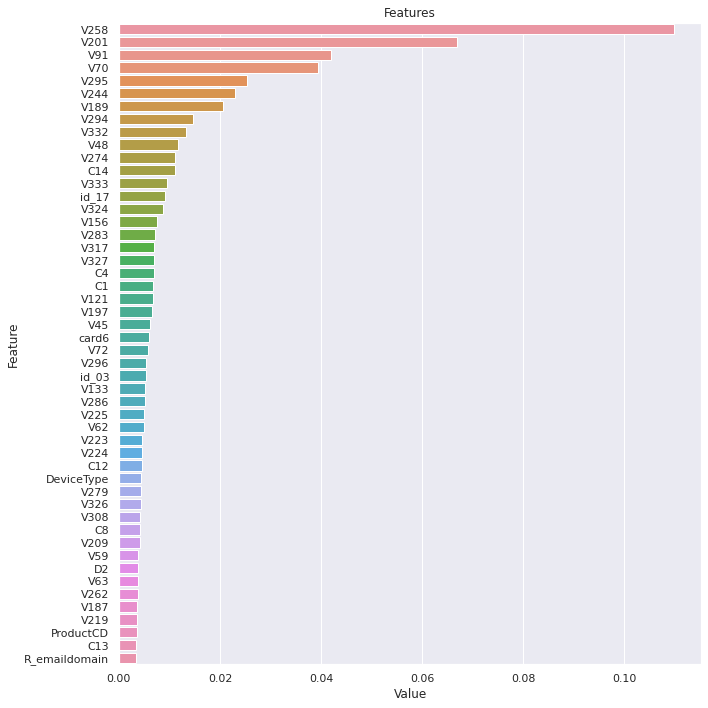

In [22]:
plot_importance(reg2, X_train)

In [23]:
predictions2 = reg2.predict_proba(test_df)[:,1]

In [24]:
submission = pd.DataFrame({'TransactionID':test_transaction['TransactionID'],'isFraud':predictions2})
submission["TransactionID"]=submission["TransactionID"].astype(int)
submission.head()

,TransactionID,isFraud
0,3663549,0.005178
1,3663550,0.002008
2,3663551,0.002815
3,3663552,0.001957
4,3663553,0.001499


In [25]:
filename = 'CIS Fraud Detection XGB.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: CIS Fraud Detection XGB.csv


In [26]:
# Score: 0.891545
# Public score: 0.916079

# Random Undersampling

# lightgbm

In [27]:
print("Before UnderSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train==0)))

undersample = RandomUnderSampler(sampling_strategy=0.2, random_state=3)

X_train_res, y_train_res = undersample.fit_resample(X, y)

print('After UnderSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After UnderSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before UnderSampling, counts of label '1': 14464
Before UnderSampling, counts of label '0': 398914 

After UnderSampling, the shape of train_X: (123978, 432)
After UnderSampling, the shape of train_y: (123978,) 

After UnderSampling, counts of label '1': 20663
After UnderSampling, counts of label '0': 103315


In [28]:
reg3 = LGBMClassifier()  
reg3.fit(X_train_res,y_train_res) 

LGBMClassifier()

In [29]:
pred3 = reg3.predict(X_test) 
print(classification_report(y_test, pred3))
print(f"Auc: {round(roc_auc_score(pred3, y_test), 2)}")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    170963
           1       0.60      0.62      0.61      6199

    accuracy                           0.97    177162
   macro avg       0.80      0.80      0.80    177162
weighted avg       0.97      0.97      0.97    177162

Auc: 0.8


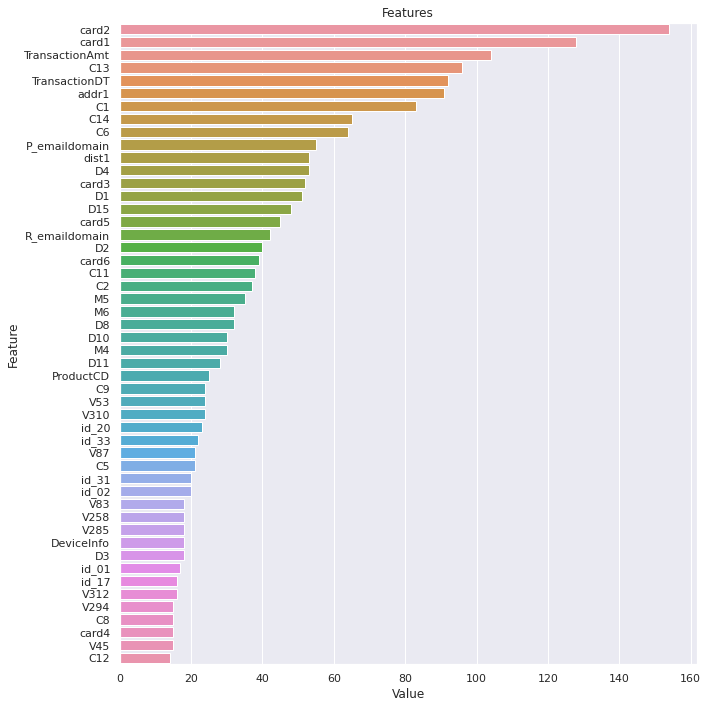

In [30]:
plot_importance(reg3, X_train)

In [31]:
predictions3 = reg3.predict_proba(test_df)[:,1]

In [32]:
submission = pd.DataFrame({'TransactionID':test_transaction['TransactionID'],'isFraud':predictions3})
submission["TransactionID"]=submission["TransactionID"].astype(int)
submission.head()

,TransactionID,isFraud
0,3663549,0.028472
1,3663550,0.037163
2,3663551,0.057610
3,3663552,0.016393
4,3663553,0.017545


In [33]:
filename = 'CIS Fraud Detection under sampling lgbm.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: CIS Fraud Detection under sampling lgbm.csv


In [34]:
# Score: 0.901909
# Public score: 0.923298

# xgb

In [35]:
reg4 = XGBClassifier()   
reg4.fit(X_train_res,y_train_res) 

[17:33:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
pred4 = reg4.predict(X_test) 
print(classification_report(y_test, pred4))
print(f"Auc: {round(roc_auc_score(pred4, y_test), 2)}")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    170963
           1       0.67      0.72      0.69      6199

    accuracy                           0.98    177162
   macro avg       0.83      0.85      0.84    177162
weighted avg       0.98      0.98      0.98    177162

Auc: 0.83


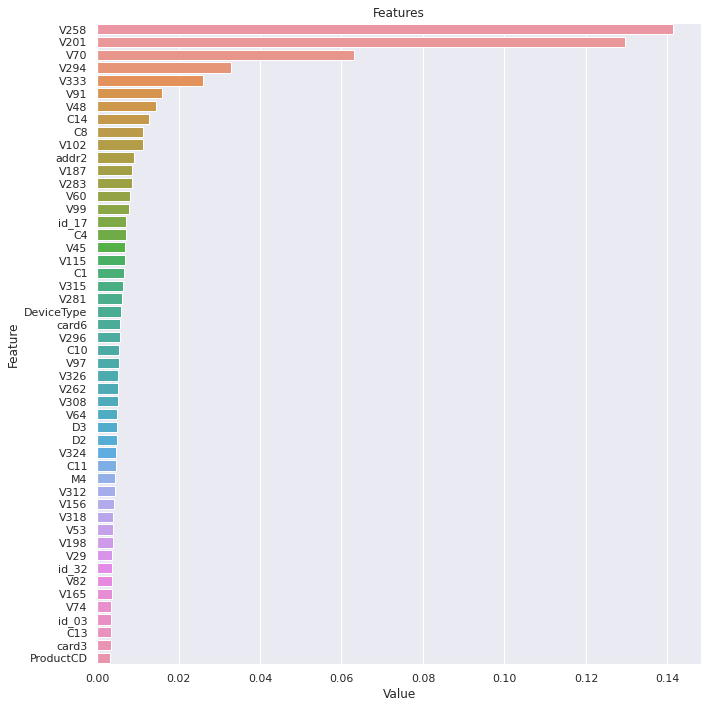

In [37]:
plot_importance(reg4, X_train)

In [38]:
predictions4 = reg4.predict_proba(test_df)[:,1]

In [39]:
submission = pd.DataFrame({'TransactionID':test_transaction['TransactionID'],'isFraud':predictions4})
submission["TransactionID"]=submission["TransactionID"].astype(int)
submission.head()

,TransactionID,isFraud
0,3663549,0.003733
1,3663550,0.007927
2,3663551,0.053587
3,3663552,0.009734
4,3663553,0.011136


In [40]:
filename = 'CIS Fraud Detection under sampling xgb.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: CIS Fraud Detection under sampling xgb.csv


In [41]:
# Score: 0.892110
# Public score: 0.920813